In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import keras
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
from keras.layers import Input
from keras import optimizers
import tensorflow as tf
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from scipy import stats
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
mp_hol = mp.solutions.holistic # model
mp_draw = mp.solutions.drawing_utils
holistic = mp_hol.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

In [4]:
def mp_detect(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    result = model.process(image) 
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, result

In [5]:
def draw_lm(image, results):
    mp_draw.draw_landmarks(image, results.pose_landmarks, mp_hol.POSE_CONNECTIONS)
    mp_draw.draw_landmarks(image, results.left_hand_landmarks, mp_hol.HAND_CONNECTIONS)
    mp_draw.draw_landmarks(image, results.right_hand_landmarks, mp_hol.HAND_CONNECTIONS)

In [6]:
def draw_styled_lm(image, results):
    mp_draw.draw_landmarks(image, results.pose_landmarks, mp_hol.POSE_CONNECTIONS,
                             mp_draw.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(image, results.left_hand_landmarks, mp_hol.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )   
    mp_draw.draw_landmarks(image, results.right_hand_landmarks, mp_hol.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(155,117,66), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(155,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
def ext_keypoints(results1):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results1.pose_landmarks.landmark]).flatten() if results1.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results1.left_hand_landmarks.landmark]).flatten() if results1.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results1.right_hand_landmarks.landmark]).flatten() if results1.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [32]:
DATA_PATH = os.path.join('Data_1') 

actions = np.array(['сәлеметсіз бе', 'сау болыңыз','аты','тегі','әкесінің аты','бір','мектеп'])

no_seq = 61

seq_length = 30

start_folder = 1

In [9]:
for action in actions: 
    for sequence in range(1,no_seq+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [33]:
label_map = {label:num for num, label in enumerate(actions)}

In [34]:
sequences, labels = [], []
for action in actions:
    for sequence in range(1, no_seq):
        window = []
        for frame_num in range(seq_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [35]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [37]:
log_dir1 = os.path.join('Logs0')
tb_callback = TensorBoard(log_dir=log_dir1)

In [38]:
model = Sequential()
model.add(Input(shape=(30,258)))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [39]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [20]:
model.fit(X_train, y_train,epochs=150, callbacks=[tb_callback])

Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - categorical_accuracy: 0.1577 - loss: 2.0724
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.3549 - loss: 1.7593
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.3722 - loss: 1.5090
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.5025 - loss: 1.2749
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.6221 - loss: 0.9448
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.5474 - loss: 1.2132
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.4013 - loss: 1.2587
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.5129 - loss: 1.1754
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.4472 - loss: 1.2157
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.5638 - loss: 1.2133
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0

In [31]:
del model

In [41]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


In [42]:
y_hat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [43]:
y_true = np.argmax(y_test, axis=1).tolist()
y_hat = np.argmax(y_hat, axis=1).tolist()

In [44]:
accuracy_score(y_true, y_hat)

1.0

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - categorical_accuracy: 0.1810 - loss: 1.9345 - val_categorical_accuracy: 0.4286 - val_loss: 1.5859
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - categorical_accuracy: 0.2748 - loss: 1.6992 - val_categorical_accuracy: 0.3333 - val_loss: 1.6157
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - categorical_accuracy: 0.3424 - loss: 1.5854 - val_categorical_accuracy: 0.3333 - val_loss: 1.1351
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - categorical_accuracy: 0.3999 - loss: 1.1744 - val_categorical_accuracy: 0.6667 - val_loss: 0.9191
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - categorical_accuracy: 0.5450 - loss: 1.0348 - val_categorical_accuracy: 0.7143 - val_loss: 0.8308
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - categorical_accuracy: 0.4990 - loss: 1.2380 - val_categorical_accuracy: 0.7619 - val_loss: 1.2817
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - categorical_accuracy: 0.5323 - lo

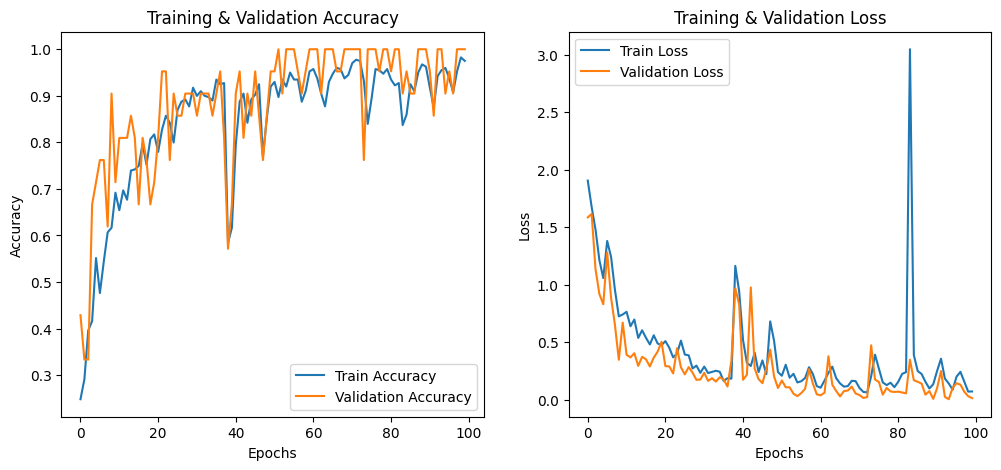

In [40]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[tb_callback])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

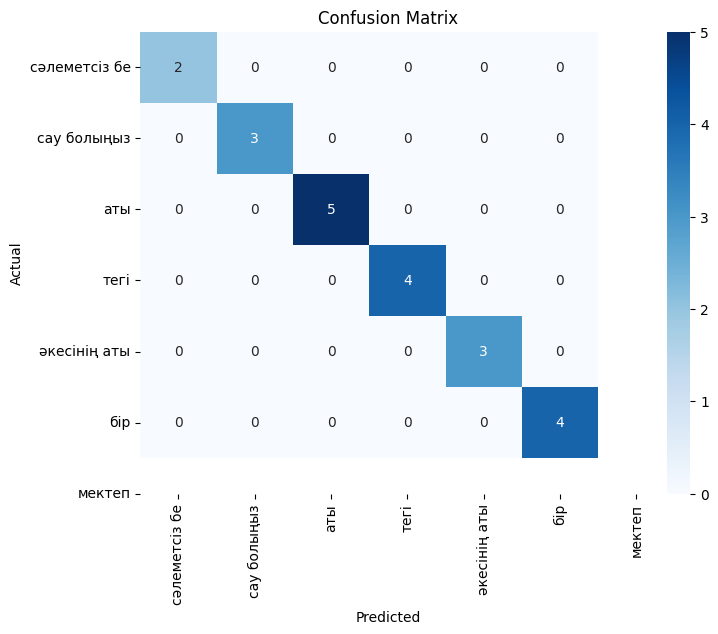

In [49]:
cm = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [60]:
from PIL import Image, ImageDraw, ImageFont

def draw_text(image, text, position=(20, 40), font_path="arial.ttf", font_size=32, color=(0, 255, 0)):
    # Конвертируем изображение OpenCV в формат PIL
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    draw.text(position, text, font=font, fill=color)

    return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)


In [62]:
def predict_gesture(model, sequence):
    sequence = np.expand_dims(sequence, axis=0) 
    prediction = model.predict(sequence)
    return np.argmax(prediction), np.max(prediction)  


cap = cv2.VideoCapture(0)

sequence = []  
threshold = 0.8  

with mp_hol.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image, result = mp_detect(frame, holistic)
        draw_styled_lm(image, result)
    
        keypoints = ext_keypoints(result)
        sequence.append(keypoints)
        sequence = sequence[-30:]  

        if len(sequence) == 30:
            action_class, confidence = predict_gesture(model, np.array(sequence))

            if confidence > threshold:
                text = f"{actions[action_class]} ({confidence:.2f})"
                image = draw_text(image, text)

            cv2.imshow('QazSign', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


C:\QazSign\python\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━